Saving your_content.jpg to your_content.jpg
Saving your_style.jpg to your_style.jpg


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 129MB/s]


Optimizing...
Step 50: Style Loss: 0.0003, Content Loss: 22.3207
Step 100: Style Loss: 0.0001, Content Loss: 23.8309
Step 150: Style Loss: 0.0000, Content Loss: 24.7679
Step 200: Style Loss: 0.0000, Content Loss: 24.9450
Step 250: Style Loss: 0.0000, Content Loss: 24.4763
Step 300: Style Loss: 0.0000, Content Loss: 23.7561


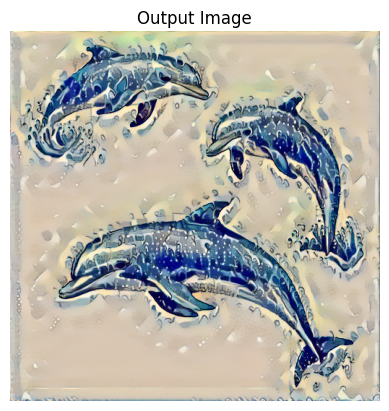

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import vgg19, VGG19_Weights
from PIL import Image
import matplotlib.pyplot as plt
import copy

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Uploading Image
from google.colab import files

uploaded = files.upload()  # Upload content and style images

content_img = Image.open("your_content.jpg")
style_img = Image.open("your_style.jpg")

# Image preprocessing
def image_loader(image_path, max_size=512):
    image = Image.open(image_path).convert('RGB')

    # Resize
    size = min(max(image.size), max_size)
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()
    ])

    image = transform(image).unsqueeze(0)
    return image.to(device, torch.float)

# Load your images here
content_img = image_loader("your_content.jpg")  # replace with your content image file
style_img = image_loader("your_style.jpg")

# Check size match
assert content_img.size() == style_img.size(), "Content and style image must be the same size"

# Display function
def imshow(tensor, title=None):
    image = tensor.clone().detach().cpu().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Load pretrained VGG19
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.to(device).eval()

# Normalization
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Normalization Module
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)
    def forward(self, img):
        return (img - self.mean) / self.std

# Content Loss Module
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()
    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

# Style Loss Module using Gram Matrix
def gram_matrix(input):
    a, b, c, d = input.size()  # batch, channel, height, width
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

# Build model with loss layers
def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img,
                                content_layers=['conv_4'], style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):

    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{i}"
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f"pool_{i}"
        elif isinstance(layer, nn.BatchNorm2d):
            name = f"bn_{i}"
        else:
            raise RuntimeError(f"Unrecognized layer: {layer.__class__.__name__}")

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target = model(style_img).detach()
            style_loss = StyleLoss(target)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Trim model after last content/style layer
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], (ContentLoss, StyleLoss)):
            break
    model = model[:i+1]

    return model, style_losses, content_losses

# Input image to optimize (start from content)
input_img = content_img.clone()

# Optimization loop
def run_style_transfer(model, content_img, style_img, input_img, num_steps=300,
                       style_weight=1e6, content_weight=1):

    optimizer = optim.LBFGS([input_img.requires_grad_()])
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                                      cnn_normalization_mean,
                                                                      cnn_normalization_std,
                                                                      style_img,
                                                                      content_img)

    print("Optimizing...")
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = sum([sl.loss for sl in style_losses])
            content_score = sum([cl.loss for cl in content_losses])
            loss = style_weight * style_score + content_weight * content_score
            loss.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                print(f"Step {run[0]}: Style Loss: {style_score.item():.4f}, Content Loss: {content_score.item():.4f}")
            return loss

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

# Run the style transfer!
output = run_style_transfer(cnn, content_img, style_img, input_img)

# Show result
imshow(output, title='Output Image')